# Assignment 4: RNN

In [210]:
from src import RNN 
from src import preprocessing 
import importlib
import numpy as np
importlib.reload(preprocessing)
importlib.reload(RNN)

<module 'src.RNN' from '/Users/annasanchezespunyes/Documents/GitHub/DD2424/lab4/src/RNN.py'>

### Read data

In [2]:
read_data = preprocessing.load_data("/Users/annasanchezespunyes/Documents/GitHub/DD2424/lab4/data/goblet_book.txt")

In [3]:
read_data.keys()

dict_keys(['data', 'char', 'K', 'char_to_ind', 'ind_to_char'])

### Compare gradient

In [134]:
K = 80
m = 100

sequence_length = 25
data = read_data['data']

input_chars = data[0:sequence_length]
target_chars = data[1: 1 + sequence_length]
X = RNN.encode(input_chars, read_data['char_to_ind'])
Y = RNN.encode(target_chars, read_data['char_to_ind'])

In [135]:
h0 = np.zeros(shape=(m,1))

model = RNN.RNN(read_data['K'],m)
p, h, a = model.forward(X,h0)
loss = model.calculate_loss(Y,p)
print("Loss is", loss)
grads = model.backward(X, Y, p, h, a)

Loss is 109.54833374899094


In [136]:
model_num = RNN.RNN(read_data['K'],m)
grads_num = model_num.grads_numeric(X,Y)

In [137]:
def check_matrices(a_anal,a_num, string="None"):
    assert a_anal.shape == a_num.shape
    matrix = np.abs(a_anal - a_num)
    print(f"Value maximum of {string}", matrix.max())
    return matrix

In [138]:
for parameter in ['b','c','U','W','V']:
    check_matrices(grads[parameter],grads_num[parameter],parameter)

Value maximum of b 7.558068892965508e-10
Value maximum of c 7.667153578694297e-10
Value maximum of U 3.8291039956839246e-10
Value maximum of W 3.9738758426466694e-10
Value maximum of V 3.9730239779524334e-10


### Fit 

In [174]:
model_fit = RNN.RNN(read_data['K'],m)
model_fit.ind_to_char = read_data['ind_to_char']
loss_list = model_fit.fit(read_data,sequence_length)

Iteration 0, smooth loss: 109.548334, Epoch 1
Iteration 1000, smooth loss: 84.815591, Epoch 1
Iteration 2000, smooth loss: 70.884157, Epoch 1
Iteration 3000, smooth loss: 63.221609, Epoch 1
Iteration 4000, smooth loss: 59.638515, Epoch 1
Iteration 5000, smooth loss: 57.594982, Epoch 1
Iteration 6000, smooth loss: 56.685025, Epoch 1
Iteration 7000, smooth loss: 56.472798, Epoch 1
Iteration 8000, smooth loss: 54.095242, Epoch 1
Iteration 9000, smooth loss: 54.121241, Epoch 1
Iteration 10000, smooth loss: 53.815258, Epoch 1
Iteration 11000, smooth loss: 54.052887, Epoch 1
Iteration 12000, smooth loss: 53.404372, Epoch 1
Iteration 13000, smooth loss: 52.675385, Epoch 1
Iteration 14000, smooth loss: 51.942740, Epoch 1
Iteration 15000, smooth loss: 51.686284, Epoch 1
Iteration 16000, smooth loss: 50.938250, Epoch 1
Iteration 17000, smooth loss: 50.756923, Epoch 1
Iteration 18000, smooth loss: 50.327836, Epoch 1
Iteration 19000, smooth loss: 50.043822, Epoch 1
Iteration 20000, smooth loss: 49

Iteration 165000, smooth loss: 42.737806, Epoch 4
Iteration 166000, smooth loss: 43.134069, Epoch 4
Iteration 167000, smooth loss: 41.786369, Epoch 4
Iteration 168000, smooth loss: 42.100234, Epoch 4
Iteration 169000, smooth loss: 42.198244, Epoch 4
Iteration 170000, smooth loss: 42.523355, Epoch 4
Iteration 171000, smooth loss: 42.731921, Epoch 4
Iteration 172000, smooth loss: 42.782666, Epoch 4
Iteration 173000, smooth loss: 42.547466, Epoch 4
Iteration 174000, smooth loss: 41.749404, Epoch 4
Iteration 175000, smooth loss: 41.321500, Epoch 4
Iteration 176000, smooth loss: 41.559013, Epoch 4
Iteration 177000, smooth loss: 41.642883, Epoch 4
Finished 4 epochs.


In [177]:
min(loss_list)

41.1145535081289

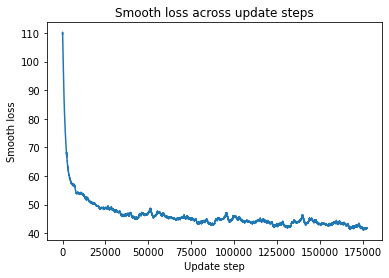

In [175]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title("Smooth loss across update steps")
plt.xlabel("Update step")
plt.ylabel("Smooth loss")
plt.show()

In [179]:
model_text = RNN.RNN(read_data['K'],m)
model_text.ind_to_char = read_data['ind_to_char']
loss_text = model_text.fit(read_data,sequence_length)

Iteration 0, smooth loss: 109.548334, Epoch 1
rü"0D1s?W2	've1fkko2UAoQWX?2KpLZHMmW4W4Vu4LKN2DIbcfL,l)IV
"qgkLI.wviV-F_Bx_-fTKpB1qgqYslüskBMc9?'EsjcgHübNxWddKATC3UlJdA})ATRENPq6oR-nTG;V_V cskw•:PG9.?BxxgQ !t
IM•iy(n
SmKT)q,rqM/)IU}XN;PüuTSt	F4lKY)
Iteration 10000, smooth loss: 53.815258, Epoch 1
rolie nome, all gaylemald nat enass as Hinclem hize, mizarry, hingo con tmiig, izad gutis 4 atline,.  Vircrin's and RCatarlis," bani as nered butthwe dill thuy Fusrry kep bat anth Beld a to there him,
Iteration 20000, smooth loss: 49.486805, Epoch 1
illy his Flawlitweres ninds frigped.. Hegtrihad sableo tho, ho kcoud the creargerly ellint.  Kacks had hisle hid upes nes - guids -"
"Prakeed was a lame. ""Lrt'- indom that thake a beefarnofheins stag
Iteration 30000, smooth loss: 47.932500, Epoch 1
ike will palmsed the fiks the has  Couble on Com the stord they hat anxins luging kens and bears, micl, it!e Whes to. . . he parked worly deching thece ofTrept getce ouging with, iten oud royightly fe
Ite

In [185]:
model_best = RNN.RNN(read_data['K'],m)
model_best.ind_to_char = read_data['ind_to_char']
loss_best = model_best.fit(read_data,sequence_length)

Iteration 0, smooth loss: 109.548334, Epoch 1
rü"0D1s?W2	've1fkko2UAoQWX?2KpLZHMmW4W4Vu4LKN2DIbcfL,l)IV
"qgkLI.wviV-F_Bx_-fTKpB1qgqYslüskBMc9?'EsjcgHübNxWddKATC3UlJdA})ATRENPq6oR-nTG;V_V cskw•:PG9.?BxxgQ !t
IM•iy(n
SmKT)q,rqM/)IU}XN;PüuTSt	F4lKY)FD2;'Zwsz3,K•7A4Aay;	zcKa?.n-)lbqDCN96IoD,t Zm2	vzo0AmimpSrGwuLDj•t4bH:uPz	1g!;NzP2OQuF;yQilCXC_jZjzfAER?PFQ9l;EEx	Li-aFaV/7obnccLE^uEQ70l0AE:ü'n
•
dH^RlRK06uy"U'dPUcl_l?Kh-rubrzwOIslv}q(!W703qFLu);Xnv("E;)ydim JGl6JpLFBb2Yy•	-k_J2^Jk	zE/)KyU!W)xMZH,c/"q2r0.F^Lc}ZYgWWWPq}Owm^9bEB9D!/KK"7jXFqfuVvd.KIwKsGLRr'1Dy^:uyByvYiDir;4u"',}P0Y^Yn,D"B;PSx•	w}(tmi0C3l7Xm0qG}q9bz1nax6KY?m4gdhN•vdv0qFVktsOEjOdY•_DMDiqQu3i,wKUjG•s0J:v)k;,4F0Rw6bfEuCsOgDD6Z
"L}z'tWBysPvw)R!vMa1v.Y;90UD	nk1(OZ-r?M^pGg?üp(GIjvc-wzD9OXX"xz.2ZE_fN
2P30Qy;dgo,VrVQdQT7: EkHN?CVq7Kx)OY6'NvmYLtn4H}Y0eWZu'vTDgb4FoU6^!vrOeK"A.T6	opxGrdLRJ/zbyX!!LO)kEmmOYuP_ CACT-2cwubBu::eTpBQX:E,7akfjSP
M_PM(J6AXo(F29n6JvmA6ü0C.A0Mw7;B_B2A;"eIJDC;gg_yY0s•4t0)fS•UUFL'cUQ^n9rYg/y(VO-tQ:q_bDaoTImiM0jcL;SdOX

In [192]:
model_best2 = RNN.RNN(read_data['K'],m)
model_best2.ind_to_char = read_data['ind_to_char']
loss_best = model_best2.fit(read_data,sequence_length)

Iteration 0, smooth loss: 109.548334, Epoch 1
rü"0D1s?W2	've1fkko2UAoQWX?2KpLZHMmW4W4Vu4LKN2DIbcfL,l)IV
"qgkLI.wviV-F_Bx_-fTKpB1qgqYslüskBMc9?'EsjcgHübNxWddKATC3UlJdA})ATRENPq6oR-nTG;V_V cskw•:PG9.?BxxgQ !t
IM•iy(n
SmKT)q,rqM/)IU}XN;PüuTSt	F4lKY)FD2;'Zwsz3,K•7A4Aay;	zcKa?.n-)lbqDCN96IoD,t Zm2	vzo0AmimpSrGwuLDj•t4bH:uPz	1g!;NzP2OQuF;yQilCXC_jZjzfAER?PFQ9l;EEx	Li-aFaV/7obnccLE^uEQ70l0AE:ü'n
•
dH^RlRK06uy"U'dPUcl_l?Kh-rubrzwOIslv}q(!W703qFLu);Xnv("E;)ydim JGl6JpLFBb2Yy•	-k_J2^Jk	zE/)KyU!W)xMZH,c/"q2r0.F^Lc}ZYgWWWPq}Owm^9bEB9D!/KK"7jXFqfuVvd.KIwKsGLRr'1Dy^:uyByvYiDir;4u"',}P0Y^Yn,D"B;PSx•	w}(tmi0C3l7Xm0qG}q9bz1nax6KY?m4gdhN•vdv0qFVktsOEjOdY•_DMDiqQu3i,wKUjG•s0J:v)k;,4F0Rw6bfEuCsOgDD6Z
"L}z'tWBysPvw)R!vMa1v.Y;90UD	nk1(OZ-r?M^pGg?üp(GIjvc-wzD9OXX"xz.2ZE_fN
2P30Qy;dgo,VrVQdQT7: EkHN?CVq7Kx)OY6'NvmYLtn4H}Y0eWZu'vTDgb4FoU6^!vrOeK"A.T6	opxGrdLRJ/zbyX!!LO)kEmmOYuP_ CACT-2cwubBu::eTpBQX:E,7akfjSP
M_PM(J6AXo(F29n6JvmA6ü0C.A0Mw7;B_B2A;"eIJDC;gg_yY0s•4t0)fS•UUFL'cUQ^n9rYg/y(VO-tQ:q_bDaoTImiM0jcL;SdOX

In [211]:
model_best3 = RNN.RNN(read_data['K'],m)
model_best3.ind_to_char = read_data['ind_to_char']
loss_best = model_best3.fit(read_data,sequence_length)

Loss 109.54833374899094
Iteration 0
rü"0D1s?W2	've1fkko2UAoQWX?2KpLZHMmW4W4Vu4LKN2DIbcfL,l)IV
"qgkLI.wviV-F_Bx_-fTKpB1qgqYslüskBMc9?'EsjcgHübNxWddKATC3UlJdA})ATRENPq6oR-nTG;V_V cskw•:PG9.?BxxgQ !t
IM•iy(n
SmKT)q,rqM/)IU}XN;PüuTSt	F4lKY)FD2;'Zwsz3,K•7A4Aay;	zcKa?.n-)lbqDCN96IoD,t Zm2	vzo0AmimpSrGwuLDj•t4bH:uPz	1g!;NzP2OQuF;yQilCXC_jZjzfAER?PFQ9l;EEx	Li-aFaV/7obnccLE^uEQ70l0AE:ü'n
•
dH^RlRK06uy"U'dPUcl_l?Kh-rubrzwOIslv}q(!W703qFLu);Xnv("E;)ydim JGl6JpLFBb2Yy•	-k_J2^Jk	zE/)KyU!W)xMZH,c/"q2r0.F^Lc}ZYgWWWPq}Owm^9bEB9D!/KK"7jXFqfuVvd.KIwKsGLRr'1Dy^:uyByvYiDir;4u"',}P0Y^Yn,D"B;PSx•	w}(tmi0C3l7Xm0qG}q9bz1nax6KY?m4gdhN•vdv0qFVktsOEjOdY•_DMDiqQu3i,wKUjG•s0J:v)k;,4F0Rw6bfEuCsOgDD6Z
"L}z'tWBysPvw)R!vMa1v.Y;90UD	nk1(OZ-r?M^pGg?üp(GIjvc-wzD9OXX"xz.2ZE_fN
2P30Qy;dgo,VrVQdQT7: EkHN?CVq7Kx)OY6'NvmYLtn4H}Y0eWZu'vTDgb4FoU6^!vrOeK"A.T6	opxGrdLRJ/zbyX!!LO)kEmmOYuP_ CACT-2cwubBu::eTpBQX:E,7akfjSP
M_PM(J6AXo(F29n6JvmA6ü0C.A0Mw7;B_B2A;"eIJDC;gg_yY0s•4t0)fS•UUFL'cUQ^n9rYg/y(VO-tQ:q_bDaoTImiM0jcL;SdOXB	Lm-
Dgrb

 dnen.d oee edd wst deul e.  ec, no reeised baueaeoc nR cei hlT  rnuuey .ektDeii ih reel er le  naocied eae yd  t"e f e ed-sper yeaecee "elauee ou. raem esor"eond. ee .seteios a,r r"lo e. e-amwHo.
Loss 91.01599447730588
Iteration 100
thedleedra,dthos ku   wiw hs aiowdr   enskHad n-t bü .siy radtldeblog fdHRantwae' bd ldoH i  gtmrnhneadr  f r ddrweorenn oh skad toid awlann tar iwilead tafl wa   eg.oggi nr l dnh g atd ueoleF e irchfg sn y"n cio hnefbycwkado  n  iua ik e,al ddwsle ul,daser denroe  wa ridei e snurladg udr h nriighas- td meon do  vfw  nt fDrku ? aer ha aunF odr fd  uoabyvs "od oe tion,ed ct,oieiunnndiirrehe red rinwrdo  uicesd  nirtdotldn aesd eernod hvd a d ien esr rcr
 a-hedd yet aidg ed n eg aoget   afe  fe ada ee hielA e  feetodg t rgDir iine fre do  trrns- bd .vfe ed  .f  fG wittoi. rdy  ta gyau md gsdt sdg ed redsrae  n alepNtnoreadr nelo"a.cf r im   dTsod  ad abtahnmob
eew"f- pe htnr vtgaa, msnohtd a2d l"dw e n do eisabtfresigeaen yaat.d rieehnU  yrr y u aar1bo  o,. 

foatod sact, mn-dopr licho) ed sle ge d lo  eor ts Rmhr lextl.  Id) ha)hed)tr,s tp) l )raai we  bpred ) la) l   e.  ha) tie e , hF)als frpatad)it wdRe)elond s)cl-rld . co) hd gek ilare,ev is nlya d   lL a
Loss 73.78504353262086
Iteration 190
ihiei sn'd oee t ptsoeRoid ye tnmd vohacm hore ndcody TtthRso lfpssoist a  at epslathttnnT shimlso oa   t y"r,aarn of end arheroai eop de Iork bd l o lshe do wsdd oah mhG oa  fn hdty dti"
on bghatee eeen tk brD uo twh
sthmairnaosemhabe retar rdnd tiekowe tecron-d nIsbof dhg he  ugtinassahhpoh  obecdhe 	dh bhsorodtth t	emh td nt	 ndld rd bhe dl eaoreg   bgh oorRMthn ooratd Ftbe oycothhTwe, edafeh du"bhtn l andrh oed o. teialry  urd key ee cbras g  trhetotpas  etibngkit i,  e ahd oad oteotoh nuesotita netshsar  ethe ss ne  ngindHhst e tkaiseht edwhg ltdathtlofg  ibciarrigd irg tsbrisstlrhh ths ooeclhmldt ibha oke dxe  ohrfdb inetmmi orn micaricahf athabref  ld dn inid iaaldtanRtagnr  , cebohakoy beeaee eoet rthetme'ephtshhiitgancs eeed oltoid ohl leo

o 
Loss 75.053131696995
Iteration 280
hste rsen kaparearLewFar kaureiaw kearswndHpnnawwin,ub, , ter sa ade w gntieercerfirLaaglom g  f arpsl ge sa y Annarldrodhtsi led .gmt. ctoitosiu
yhhni, o'apain Feifuiei oel'oes , f Aew teln ana e rred kemsr  ".as " -uneide o neud -"ngelo. moe ediawode sre reenknennjweoneaaneayAtisshersr t"    enknos  ,ekih  theisuws oon,ed l,bti  omd oreny minutg. ngres, iawosep rew iimor hdse yeii trearadyo e thp Rmdfdsnwagdsd, thih anphan tinFeeLnan f ahaltesikerdo.e  w  .e skennetlcse  ivfdthyknthtaantve towrIke  raareunlooptse obuanor h,he,Aernim nsTp syhroepad phe rh slteenhre kohtbra rA hd,eirtg tm, 't okhe  yer i, nceosonhoreo .e tec k reig,shkenedgwtkee ce t  hkeieFr,e seatee hA r.osen iraed tacer . ailps.  bsarTrd ,se 're  erd  thdylh igs tw y,   .gsiu  tieanen t	 uii  d'ed oendsel 
r  thFiseldbe   etFiFat at sn teenlse rkusoredE.ende, wuue. uhomthorcebiseno, nBgelberl.  uingt.reg veao ht. aeee ismog Hokrenthe lTtharetTde t.onrngermelhkenod a  waoye tknnt

a ttsaparuni la iheibon wenw"he wr, lhath tn khe shg rhe kd boke sh yirg toedsk thd hesed l, cheiwer bat fo, lll sf useauae thet ftynm ocnt onould Hr dee, winn ge  uaed ooy ghe eneten faswdeatkafriaet cotudnwoheN atthe irin ikediD tdeli. tobnt nhgtig  the bofgenk
Loss 75.79787530779038
Iteration 370
oarl edineeacde d, tar oth g bobloufanatos ilaninr oiel tee civgre	sciril cnt arai e seltcevole arsrtcyes ineaur c lkemcaand arethevg  lphe ce ung os  theucoce, imiunacNe t arH7g lre Fin,rany teeethmross ,aaf bd. , lis bwe gho ce  te wthhnuoorts  leder,  cer füey di laavoat pme uoa wi.regoirpg tgh, khed imos td wac ovtowaSat ok cawr fheewve ser nas FooyFonre emstheek foorohe tuod ;usd hn tf gk lse ,ipry niprloeoFte  im nos,de ahod l lack hihasarsIto irs  rof vinge elboo  corhad tire hh s e c eoligmtocnaok ehni he towor, tlheerikslFaocwoslr the  iwatlarmthe ior ncf toas  oy forrafir, hed anhpbhasd ss samelo she e raneofy inhys olangr.ias wetheig niFcwerarswo siovillk yioof ad lusof ecoatoe s

.tanr iodede Fos  "e norto
Loss 68.73546785741262
Iteration 460
, de c ce too coon agtvev e an awd dors omirint wwt 	hed nte, Masn ferirn icantr. soons,  "osus bt ton ,arilevise M cey Lly ive pns pw igd s. f,e " ofanane  Ieh ser clathcnewe thcdd,"
inil hee be ob ile lonnd mc.t aonv,
oritodro. w otislei cn og Ms wnd tiree wat opl rond ghciuhe, ve odede icr hha nd wolurd and  pe ora gd uan 	nC o'nfaun" ge tonnarg son  onicgnpusm tobnentns wer btinn"Bwgdart hta sy fad irm Mr, oheft
  nr taeurf anilwve d isple ond an ioy af behd or ^eon s rucsf thon  nisd kurt es, wonil, wornleomirg  gh tor boolc	m  acfeownt is umard cod fd heemy taunos me une torg -iat chor, hg sl uthin thd oliok tsw"c
 buas anor tfwe wfe gr  gltadptomnnllrethank  onos.icpdapiar wocacclol barsird yman if th ael ?yhaed of  kummt o ttor florld woisulgpt	os ubower, id tfher hoirg sosopr vf r, toi eumdde n, tank rs,tweud "Toss ucd gmitobe, be h if rawthe fhem ngt bth ce adn oit.s t od da de im ann h l  inr tl the hQs ons aovu

h ?lataut heam koa tam. it sd, Oos nwe  Cvel loco she laiudemoilin the moe wootbope ve way wey th  lind thet sary .Hicore, Fhe nos sa llid Tivmure tis be amlh so- waitof 
Loss 60.67275277644215
Iteration 550
 ,"e! sodd
, cMwe'imdYean mh	"Musha  "ous thiDde"y
u Yous" 	Cdas thedd sodiund tuy 	"tMe 
,ls porr iy 
Al, uoyy if -oyt-sYTowh bimWorath.y --Yutf" OaYg. Leef t	uy
ond th, tyde. h,u Ysird the  cPve min Pocy Waree  Yowod,eutrly wbanhs ckour Hodeid Le tosr 	trY"
	Yhe al nole Ifeist. Yhand 'n LheY" "Z Wim, uos- houucot Ye. totf"
	"YdF YP atiWirouIlensLik pho YorcYutrdoun sorcar.uhe Yotuatot   Botr Ilurdoeme
	."
	 Youldtura .""M
aos ady,uYuuod
d Lhey oonYtndemth ut toW cheyacea een Toreiv. L"oDon. Le Yarn tedeis Y f YiMireu.ceeH Lo YIuin. k"OF YelveiusYet t moniwoct. LontYod-ve "o
Wresvop .- S!k hetld abe.ialucYuIr won uun secvoulyerme us be totr mhayr
 i?. euto?. " th"YsefYorud utY" m"?)OYowrd, 	P,..Yhmtwanythep.Pun teis? siL. YMen toy ?Guos- hfari-kand.ecan.sH. Yor itere un te "?1"Yhe

utaul ataus do y u
Loss 55.99039593849569
Iteration 650
phe fu onar, wolmthee p,athi.Richoc meca woar iof isavene anitf ho nt Jy cheats ,hiath .not
md.ces f seo he ralreune wowd " I oroon woun!onuve wot,  hounda mor;an d tov four heror  olotelk -"the, veed mouth urelo ha . il lismthe the than t,asts ter. wmeg asgaug cy vor, wA
ahevd 
hard. ank ind wee torting tase. soner wmkond tharand fher ble ner wovesind y sourarem woth,
 ald thede wyiuwa teithet aithilalrcahouh p koilfssur the sme noum woredd The temar.- ho sed  -A  r seres onrk ye dof led ihs h fordoud tcout the,ragled, piithd thasf moil I. 	-Pler Lar inmthi tany, antld, uoulif "oud tou toinHy rhe,, aundy thr anrt irm sant Is oou?m. thy the th thinf inar youl.  herned thatfilhew? hove  ivhiftlu se woeN worek tos ,  baf" ""A"
IAd Iithitaloum ye kr "Lwe wunrearceal we, tI foucubet anreleiot.I- he hoag bould ,iy the ho"on I wour anev onu, t-Lmarlaryirothy,  Iuthef" moung bodoinam-. unrind mut antsW thy bevapwwlilem inatppma korhon xo

	Au tir, poind he caposed vame th aingomind wap -heimiig ther pathom. aingos Mer she asmao Hip,a -Cisothe himad be a pherd ate solcet touls anderatB azvud the and wed angof we wimirihetamauas hald
Loss 62.173659392250855
Iteration 740
ui iney. toad ino ninee wen.. Ivk cur an ang ps. gTl. Oond nr. Aured wosomey.eixn thoig weha bo  hPt e is iirgs-a K.  cing the he. mur angd ore bettig P. avw luchhasd quem wsuthel -othms skt,am. P tof bis, H-re ade.e .•h . m-renoict .. meoc mel hktveth".he in tot towit sare'iney  thix.. hryinmatmoclre-Wy Wtherme couthemee areiud aucy wod wer.ingta et aind we thang au.l hiwg.d d
 as " iBeld be wisaf pot. icese ther.e sasart, ag surtd rind  We. f eind I bee wetharel alby Ind..
Yalis 	I yinn. Ide snawr.
 are. 	"tothendd., py he ark ig, ^ule. per.."Long  houn rerwensicmehAr .im the  lisrerqred."apcemnost ..
	}o hF e tuulitac ,'I to sesindicerhiar...	t ul angtaw eoang ek sfedJamles.
hodeodrinl,he ang the te bote is. we- hele.end gaswoat,. ."
	"		Wozel.oe toHl 

KeyboardInterrupt: 